## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

---


## Setup and Imports

1. Importing libraries
2. Useful functions definition

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random



# show accuracy and loss of train data and validation data trainings
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# show confusion matrix between true and predicted labels
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.8.0


## Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [2]:
from datasets import load_dataset
dataset = load_dataset("emotion")

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
train=dataset['train']
val=dataset['validation']
test=dataset['test']

In [5]:
def get_tweet(data):
    tweets=[x['text'] for x in data]
    labels=[x['label'] for x in data]
    return tweets, labels

In [6]:
tweets, labels = get_tweet(train)

In [7]:
for i in range(5):
    print(f"('{tweets[i]}', '{labels[i]}')")

('i didnt feel humiliated', '0')
('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', '0')
('im grabbing a minute to post i feel greedy wrong', '3')
('i am ever feeling nostalgic about the fireplace i will know that it is still on the property', '2')
('i am feeling grouchy', '3')


In [8]:
#labels.replace({0:"sadness", 1 :"joy", 2:"love",3:"anger",4:"fear"})
# for i in range(len(labels)):
#     if labels[i] == 0:
#         labels[i] = "sadness"
#     if labels[i] == 1:
#         labels[i] = "joy"
#     if labels[i] == 2:
#         labels[i] = "love"
#     if labels[i] == 3:
#         labels[i] = "anger"
#     if labels[i] == 4:
#         labels[i] = "fear"
#     if labels[i] == 5:
#         labels[i] = "surprise"
# labels
#sadness (0)
#joy (1)
#love (2)
#anger (3)
#fear (4).

## Tokenizer

1. Tokenizing the tweets

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [10]:
tokenizer=Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [11]:
print(tweets[1])
tokenizer.texts_to_sequences([tweets[1]])

i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake


[[2,
  40,
  101,
  60,
  8,
  15,
  494,
  5,
  15,
  3496,
  553,
  32,
  60,
  61,
  128,
  148,
  76,
  1480,
  4,
  22,
  1255]]

## Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

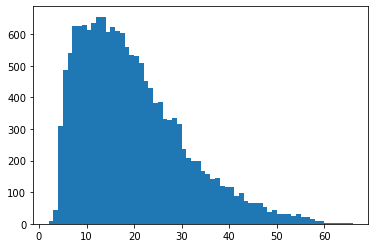

In [12]:
lengths=[len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [13]:
maxlen=50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [14]:
def get_sequences(tokenizer, tweets):
    sequences=tokenizer.texts_to_sequences(tweets)
    padded=pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
    return padded

In [15]:
padded_train_seq=get_sequences(tokenizer, tweets)

In [16]:
padded_train_seq[1]

array([   2,   40,  101,   60,    8,   15,  494,    5,   15, 3496,  553,
         32,   60,   61,  128,  148,   76, 1480,    4,   22, 1255,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])

## Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [17]:
classes=set(labels)
print(classes)

{0, 1, 2, 3, 4, 5}


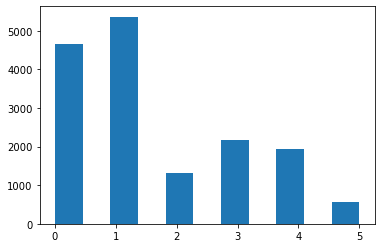

In [18]:
plt.hist(labels, bins=11)
plt.show()

In [19]:
class_to_index=dict((c,i) for i,c in enumerate(classes))
index_to_class=dict((v,k) for k,v in class_to_index.items())

In [20]:
class_to_index

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [21]:
index_to_class

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [22]:
names_to_indexes=lambda labels: np.array([class_to_index.get(x) for x in labels ])

In [23]:
train_labels=names_to_indexes(labels)

In [24]:
train_labels[0:5]

array([0, 0, 3, 2, 3])

## Creating the Model

1. Creating the model
2. Compiling the model

In [25]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(input_dim=10000, output_dim=16, input_length=maxlen),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=20, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=20)),
  tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Training the Model

1. Preparing a validation set
2. Training the model

In [27]:
val_tweets, val_labels = get_tweet(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = names_to_indexes(val_labels)

In [28]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [29]:
hypothesis = model.fit(
    x=padded_train_seq,
    y=train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 34s 49ms/step - loss: 1.3503 - accuracy: 0.4625 - val_loss: 0.8799 - val_accuracy: 0.6845
Epoch 2/20
500/500 [==============================] - 22s 44ms/step - loss: 0.6918 - accuracy: 0.7355 - val_loss: 0.6853 - val_accuracy: 0.7475
Epoch 3/20
500/500 [==============================] - 22s 43ms/step - loss: 0.4674 - accuracy: 0.8404 - val_loss: 0.5570 - val_accuracy: 0.8185
Epoch 4/20
500/500 [==============================] - 21s 42ms/step - loss: 0.3181 - accuracy: 0.8938 - val_loss: 0.4810 - val_accuracy: 0.8380
Epoch 5/20
500/500 [==============================] - 21s 43ms/step - loss: 0.2358 - accuracy: 0.9206 - val_loss: 0.4639 - val_accuracy: 0.8555
Epoch 6/20
500/500 [==============================] - 22s 44ms/step - loss: 0.1883 - accuracy: 0.9346 - val_loss: 0.4365 - val_accuracy: 0.8620
Epoch 7/20
500/500 [==============================] - 21s 43ms/step - loss: 0.1539 - accuracy: 0.9434 - val_loss: 0.4261 - val_accuracy:

## Evaluating the Model

1. Visualizing training history
2. Preparing a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

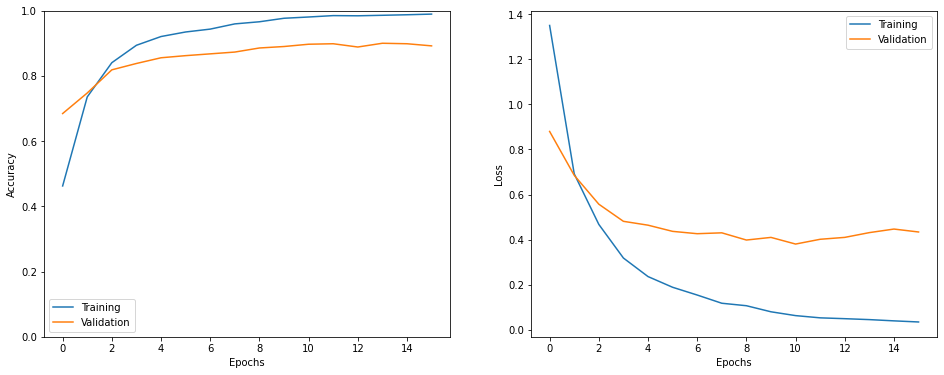

In [30]:
show_history(hypothesis)

In [31]:
test_tweets, test_labels = get_tweet(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = names_to_indexes(test_labels)

In [32]:
_ = model.evaluate(x=test_sequences, y=test_labels)

63/63 [==============================] - 1s 17ms/step - loss: 0.4379 - accuracy: 0.8860


In [33]:
i = random.randint(0, len(test_labels)-1)

print(f'Tweet : {test_tweets[i]}')
print(f'Emotion : {index_to_class[test_labels[i]]}')

i_prediction = model.predict(np.expand_dims(test_sequences[i], axis=0))[0]
predicted_class = index_to_class[np.argmax(i_prediction).astype('uint8')]

print(f'\nTweet : {test_tweets[i]}')
print(f'Predicted Emotion : {predicted_class}')

Tweet : i know nothing is going to change even i feel very envious to these people but i cant stop feeling jealous to these people because its a human beings instinct to act so
Emotion : 3

Tweet : i know nothing is going to change even i feel very envious to these people but i cant stop feeling jealous to these people because its a human beings instinct to act so
Predicted Emotion : 3


In [34]:
predictions = model.predict(test_sequences)
predicted_classes = np.argmax(predictions, axis=1)

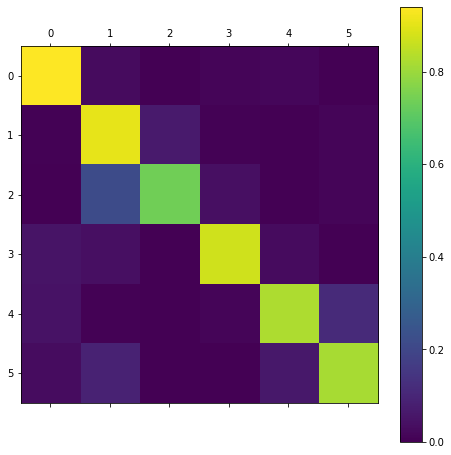

In [35]:
show_confusion_matrix(test_labels, predicted_classes, list(classes))

In [ ]:
#     if labels[i] == 0:
#         labels[i] = "sadness"
#     if labels[i] == 1:
#         labels[i] = "joy"
#     if labels[i] == 2:
#         labels[i] = "love"
#     if labels[i] == 3:
#         labels[i] = "anger"
#     if labels[i] == 4:
#         labels[i] = "fear"
#     if labels[i] == 5:
#         labels[i] = "surprise"
# labels